In [43]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
* {font-family:D2Coding;}
div.container{width:87% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input { font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:3px;}
table.dataframe{font-size:12px;}
</style>
"""))

<font size=5 color=red>06_피마인디언_당뇨병발병예측(로지스틱회귀분석=인진분류,분류분석)</font>

In [44]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras import utils # utils.tocategorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from matplotlib import pyplot as plt

# 로직스틱회귀분석(이진분류)

## 1. 데이터셋 생성 & 전처리

In [3]:
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
df.info() # 결측치 없음
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


(768, 9)

In [4]:
# 타켓 변수의 균형
df.iloc[:,-1].value_counts()

0    500
1    268
Name: 8, dtype: int64

In [5]:
df.head()
# X_data = df.iloc[:,-1].values

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# csv 파일을 numpy 로 읽어오기 : np.loadtxt(결측치가 없는 경우, header도 없는 경우), np.genformattxt(결측치가 있을 경우)
dataset = np.loadtxt('data/pima-indians-diabetes.csv', delimiter=',')
dataset.shape

(768, 9)

In [7]:
# 데이터 분할 : 학습데이터셋(모델학습용) + 시험데이터셋(모델평가용)
X_train = dataset[:700, :-1]
y_train = dataset[:700, -1]

X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 8), (700,), (68, 8), (68,))

## 2. 모델 구성

In [8]:
model = Sequential()

# 입력이 8개 → 16개 → 32개 → 64개 → 32개 → 16개 → 8개 → 결과 1개 
# 시간상 아래와 같이    
# 입력이 8개 → 32개 → 16개 → 결과 1개
#          relu         sigmoid

model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


2025-06-12 14:22:05.110573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. 학습과정 설정

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["binary_accuracy"])

## 4. 학습

In [10]:
%%time
hist = model.fit(X_train, y_train, # 훈련테이터
                 epochs=200, # 학습횟수
                 batch_size=350, # 한번에 읽어들이는 데이터 양 (메모리 상태에 따라 조정)
                 # validation_data=[X_test, y_test] # 검증데이터
                 # validation_split=0.1, # 자동으로 훈련데이터에서 0.1(10%)를 빼서 검증
                 verbose=0 # 학습 로그 출력 여부 (0:출력없음, 1:출력, 2: 출력자세히)
                )

CPU times: user 1.55 s, sys: 152 ms, total: 1.7 s
Wall time: 1.3 s


## 5. 모델 평가하기 (학습과정 보기, 평가, 혼동행렬=교차표)

In [11]:
hist.history
hist.history.keys()

dict_keys(['loss', 'binary_accuracy'])

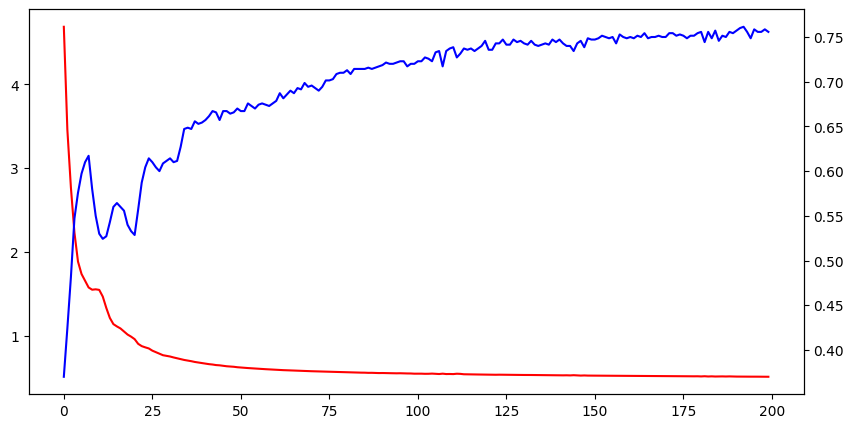

In [12]:
# 학습과정 표시 (학습데이터에 대한 'loss', 'accuracy')

# 'loss', 'accuracy'
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'],'r')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history['binary_accuracy'],'b')

In [13]:
# 모델 평가 (x)

model.evaluate(X_train, y_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.5156 - binary_accuracy: 0.7600


[0.5155624747276306, 0.7599999904632568]

In [14]:
# 모델 평가 (O)

model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.6126 - binary_accuracy: 0.6471


[0.6126115322113037, 0.6470588445663452]

## 혼동행렬 = 교차표

- 테스트 데이터 셋의 실제값과 예측값으로 작성된 교차표

In [15]:
y_test[:5]

array([0., 1., 1., 0., 0.])

In [16]:
# 실재값 : y_test (68개)
# 예측값
y_hat = (model.predict(X_test) >= 0.4).astype(float)
y_hat[:5]

3/3 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [17]:
TN = 0  # 0을 0으로 예측한 경우의 수(T)
FP = 0  # 0을 1로 예측한 경우의 수 (F)
FN = 0  # 1을 0으로 예측한 경우의 수 (F)
TP = 0  # 1을 1로 예측한 경우의 수 (T)

print(y_test.shape, y_hat.shape)

for y, h in zip(y_test, y_hat.reshape(-1)):
    # print(y, h)
    if y == 0 and h == 0:
        TN += 1
    elif y == 0 and h == 1:
        FP += 1
    elif y == 1 and h == 0:
        FN += 1
    else:
        TP += 1

print(TN, FP)
print(FN, TP)

(68,) (68, 1)
31 10
15 12


In [18]:
# 교차표
ctab = pd.crosstab(y_test, # 실제값
                   y_hat.reshape(-1) # 예측값(1차원으로)
                  )

ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

pd.crosstab(
    y_test,  # 실제값
    y_hat.reshape(-1),  # 예측값(1차원으로)
    rownames=['실제값'],
    colnames=['예측값'])

예측값,0.0,1.0
실제값,,
0.0,31,10
1.0,15,12


In [19]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, 
                 y_hat.reshape(-1))

array([[31, 10],
       [15, 12]])

In [20]:
# accuracy (정확도) = (TN + TP) / (TN + FP + FN + TP)
# precision (정밀도) = TP / (FP + TP) : 예측값기준
# recall (재현율) = TP / (FN + TP) : 실재값기준 

# f1 score = recall과 precision 의 조화평균

#       precision * recall
# 2 *  --------------------
#       precision + recall

# precision ↑ → recall ↓
# recall    ↑ → precision ↓ 

# precision (정밀도)를 높일려면 확실한 것만 Positive로 예측.
# recall (재현율)을 놓일려면 조금이라도 가능성이 있으면 Positive로 예측.

In [21]:
# accuracy
print('accuracy :', (TN + TP) / (TN + FP + FN + TP))
print('recall :', (TP) / (FN + TP) )
print('precision :', (TP) / (FP + TP))

accuracy : 0.6323529411764706
recall : 0.4444444444444444
precision : 0.5454545454545454


## 6. 모델사용

In [22]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [23]:
int(model.predict(np.array([[2, 122, 76, 27, 200, 35.9, 0.483, 26]])) >=0.5)

1/1 [==============================] - 0s 20ms/step


0

In [24]:
model.predict([[2, 122, 76, 27, 200, 35.9, 0.483, 26],
              [6., 125., 78., 31., 0., 27.6, 0.565, 49.]]).astype(int)

1/1 [==============================] - 0s 39ms/step


array([[0],
       [0]])

# 분류분석

1. 데이터셋 생성 및 전처리 : 훈련셋(600개), 검증셋(100), 테스트셋(68)
2. 모델생성(input 8개, output 2개) : 출력층 softmax(출력합을 1) 
    * model.summary() 파라미터 수와 메모리 확인
3. 모델 학습과정 설정 : loss='categorical_crossentropy', metirics=['accuracy']
4. 모델 학습 : 훈련셋과 검증셋
5. 모델 평가 : 그래프(hist.history), 평가(테스트셋), 교차표(테스트셋)
6. 모델 저장 및 사용 : predict()결과에 argmax()
    * 결과물 : [0 99.2, 1 0.8]    

## 1. 데이터셋 생성 및 전처리

In [25]:
dataset = np.loadtxt('./data/pima-indians-diabetes.csv', delimiter=',')
dataset.shape

(768, 9)

In [26]:
# 훈련셋(600), 검증셋(100), 테스트셋(68)
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]

X_val = dataset[600:700, :-1]
y_val = dataset[600:700, -1]

X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [27]:
# 타켓변수의 원핫인코딩 (분류분석)

# print(y_train[:5])
# print(utils.to_categorical(y_train[:5]))

Y_train = utils.to_categorical(y_train)
Y_val = utils.to_categorical(y_val)
Y_test = utils.to_categorical(y_test)

y_train.shape, Y_train.shape, Y_val.shape, Y_test.shape


((600,), (600, 2), (100, 2), (68, 2))

## 2. 모델 생성(input 8개, output 2개)

- 과적합 줄이는 단계 추가 (dropout 추가)

In [28]:
# 과적합 줄이는 단계 추가
from tensorflow.keras.layers import Dropout

model = Sequential()

model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2)) # 과적합을 해결하고자 20%를 버린다.
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1)) # 과적합을 해결하고자 10%를 버린다.
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2)) # 과적합을 해결하고자 20%를 버린다.
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                

## 3. 학습과정 설정

In [29]:
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

## 4. 모델학습

In [30]:
hist = model.fit(X_train, Y_train, 
                epochs=300,
                validation_data=(X_val, Y_val),
                verbose=1
                )

Epoch 1/300
19/19 [==============================] - 1s 14ms/step - loss: 4.5239 - accuracy: 0.4633 - val_loss: 1.4231 - val_accuracy: 0.6500
Epoch 2/300
19/19 [==============================] - 0s 6ms/step - loss: 2.3216 - accuracy: 0.5117 - val_loss: 1.0525 - val_accuracy: 0.6400
Epoch 3/300
19/19 [==============================] - 0s 4ms/step - loss: 1.7427 - accuracy: 0.5450 - val_loss: 0.6837 - val_accuracy: 0.6300
Epoch 4/300
19/19 [==============================] - 0s 7ms/step - loss: 1.7132 - accuracy: 0.5500 - val_loss: 0.7434 - val_accuracy: 0.6200
Epoch 5/300
19/19 [==============================] - 0s 4ms/step - loss: 1.1614 - accuracy: 0.5650 - val_loss: 0.6857 - val_accuracy: 0.6200
Epoch 6/300
19/19 [==============================] - 0s 4ms/step - loss: 0.9440 - accuracy: 0.5900 - val_loss: 0.6513 - val_accuracy: 0.6100
Epoch 7/300
19/19 [==============================] - 0s 4ms/step - loss: 1.0423 - accuracy: 0.5933 - val_loss: 0.6400 - val_accuracy: 0.6100
Epoch 8/300


Epoch 59/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6483 - val_loss: 0.5894 - val_accuracy: 0.7000
Epoch 60/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6717 - val_loss: 0.5865 - val_accuracy: 0.7100
Epoch 61/300
19/19 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6717 - val_loss: 0.5806 - val_accuracy: 0.7200
Epoch 62/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.6717 - val_loss: 0.5800 - val_accuracy: 0.7100
Epoch 63/300
19/19 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6850 - val_loss: 0.5814 - val_accuracy: 0.7000
Epoch 64/300
19/19 [==============================] - 0s 3ms/step - loss: 0.6092 - accuracy: 0.6667 - val_loss: 0.5857 - val_accuracy: 0.7000
Epoch 65/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5975 - accuracy: 0.6750 - val_loss: 0.5804 - val_accuracy: 0.7200
Epoch 

19/19 [==============================] - 0s 4ms/step - loss: 0.5403 - accuracy: 0.7117 - val_loss: 0.5333 - val_accuracy: 0.7400
Epoch 174/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5633 - accuracy: 0.7083 - val_loss: 0.5515 - val_accuracy: 0.7200
Epoch 175/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7067 - val_loss: 0.5519 - val_accuracy: 0.7300
Epoch 176/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5639 - accuracy: 0.7033 - val_loss: 0.5604 - val_accuracy: 0.7200
Epoch 177/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5431 - accuracy: 0.7200 - val_loss: 0.5420 - val_accuracy: 0.7400
Epoch 178/300
19/19 [==============================] - 0s 3ms/step - loss: 0.5599 - accuracy: 0.6917 - val_loss: 0.5414 - val_accuracy: 0.7400
Epoch 179/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.7417 - val_loss: 0.5415 - val_accuracy: 0.7400
Epoch 180/300

19/19 [==============================] - 0s 4ms/step - loss: 0.5108 - accuracy: 0.7583 - val_loss: 0.5701 - val_accuracy: 0.7000
Epoch 288/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.7317 - val_loss: 0.5827 - val_accuracy: 0.6900
Epoch 289/300
19/19 [==============================] - 0s 5ms/step - loss: 0.5106 - accuracy: 0.7350 - val_loss: 0.5681 - val_accuracy: 0.7000
Epoch 290/300
19/19 [==============================] - 0s 5ms/step - loss: 0.5171 - accuracy: 0.7433 - val_loss: 0.5678 - val_accuracy: 0.7000
Epoch 291/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7283 - val_loss: 0.5704 - val_accuracy: 0.6900
Epoch 292/300
19/19 [==============================] - 0s 4ms/step - loss: 0.5323 - accuracy: 0.7233 - val_loss: 0.5747 - val_accuracy: 0.7100
Epoch 293/300
19/19 [==============================] - 0s 5ms/step - loss: 0.5221 - accuracy: 0.7233 - val_loss: 0.5428 - val_accuracy: 0.6800
Epoch 294/300

## 5. 학습과정 살펴보기

In [31]:
hist.history
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

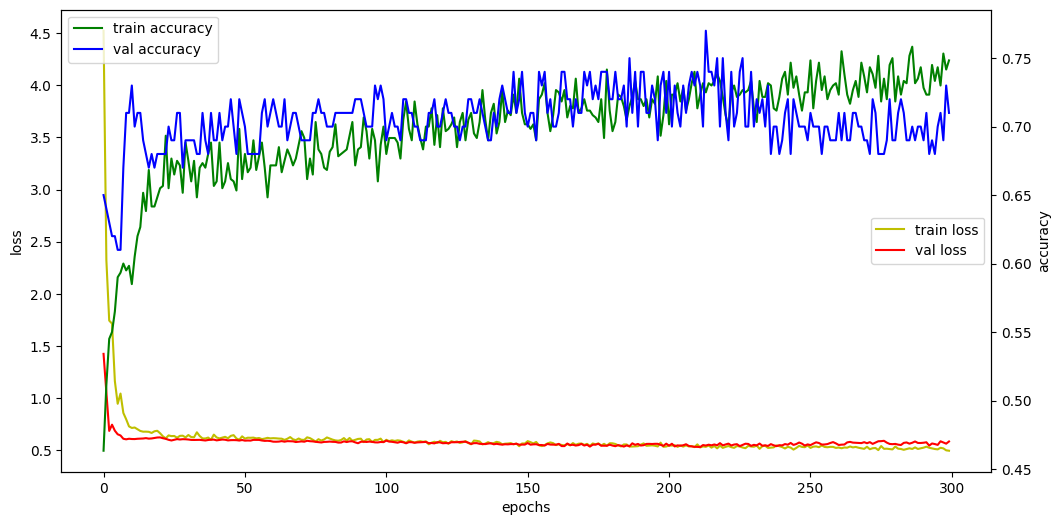

In [32]:
# 학습과정 표시 (학습데이터에 대한 'loss', 'accuracy')

# 'loss', 'accuracy'
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'],'y', label='train loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val loss')



acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history['accuracy'],'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'],'b', label='val accuracy')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

## 6. 모델 평가 & 교차표

In [33]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'loss : {loss}, 정확도 : {accuracy}')

loss : 0.7020083069801331, 정확도 : 0.6323529481887817


In [34]:
# 교차표
# y_test
Y_test.argmax(axis=1) # 실제값 y_test

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0])

In [35]:
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 2ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [36]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,41,0
1.0,25,2


In [37]:
confusion_matrix(y_test, y_hat)

array([[41,  0],
       [25,  2]])

## 7. 모델 저장 및 사용

In [38]:
print(X_test[0])
print(X_test[1])

[  2.    122.     76.     27.    200.     35.9     0.483  26.   ]
[  6.    125.     78.     31.      0.     27.6     0.565  49.   ]


In [39]:
from tensorflow.keras.models import save_model, load_model

# model.save('./model/06_pima.h5')
save_model(model,'./model/06_pima.h5')

In [40]:
model2 = load_model('./model/06_pima.h5')

In [41]:
pred = model2.predict([[2., 122., 76., 27., 200., 35.9, 0.483, 26.],
                [6., 125., 78., 31., 0., 27.6, 0.565, 49.]])
pred.argmax(axis=1)

1/1 [==============================] - 0s 99ms/step


array([0, 0])

In [42]:
np.argmax(pred, axis=1)

array([0, 0])